<font size="5">
 <div class="alert alert-block alert-info"><b>Master in Data Science - Iscte <b>
     </div>
</font>   
    
<font size="5"> OEOD </font>


<font size="3"> Afonso Fareleiro, Armando Ferreira, Tomás Carvalho </font>
  
<font size="3"> Group 12 - ticker ’MU’ </font> 

# RL for algorithmic trading

In [1]:
# import libraries

import yfinance as yf  # import data from web (financial time series)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  ## interactive data visualization

# high-quality figures
%config InlineBackend.figure_format = 'svg'

## 1. Obtain/Extract the historical stock prices

In [2]:
# Historical stock price data for MU , from the period 2016 to 2022
## 'MU': Micron Micron Technology, Inc is US based semiconductor company

mu = yf.Ticker("MU")
data = mu.history(start="2016-01-01", end="2022-12-31")

data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-04 00:00:00-05:00,13.614149,14.135877,13.594462,14.106345,22622300,0.0,0.0
2016-01-05 00:00:00-05:00,14.194941,14.844640,14.135877,14.588697,29806700,0.0,0.0
2016-01-06 00:00:00-05:00,14.273692,14.460726,13.889778,13.998062,26835100,0.0,0.0
2016-01-07 00:00:00-05:00,13.643682,14.047284,13.417273,13.446804,26029200,0.0,0.0
2016-01-08 00:00:00-05:00,13.564929,13.732276,13.082577,13.121953,29064200,0.0,0.0


<Axes: xlabel='Date'>

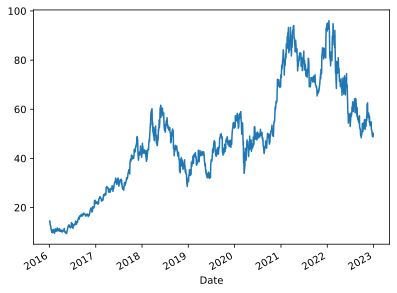

In [3]:
data.Close.plot()

## 2. Calculate the returns, expected mean returns, and the risk.

In [4]:
'''Insert code here'''

'Insert code here'

## 3. Define statistical trading strategy (at least one, maximum 2).

In [5]:
'''Insert code here'''

'Insert code here'

## 4. Evaluate the efficacy of the trading strategy.

In [6]:
'''Insert code here'''

'Insert code here'

## 5. Use at least one reinforcement learning algorithm for trading the assets (Q-learning, deep Q-learning).

In [7]:
'''Insert code here'''

'Insert code here'

## 6. Evaluate the efficacy of the trading strategy.

In [8]:
'''Insert code here'''

'Insert code here'

## 7. Fine-tune your algorithms.

In [ ]:
'''Insert code here'''

## 8. Compare and interpret the results.

In [ ]:
'''Insert code here'''